# Trainieren des Sentimentmodells

In diesem Notebook wird ein Modell trainiert, welches Tweets live auf ihre Stimmung bewerten soll. Dafür wird ein Deep Neural Network erstellt, welches mit 1.6 Millionen Tweets trainiert wird. Hierbei handelt es sich um ein Klassifikationsproblem, es soll letztendlich entschieden werden, ob ein Tweet negativ (0), oder positiv (1) gestimmt ist.

### Technologien

Für das Modell wird [Tensorflow](https://www.tensorflow.org/) verwendet, zum plotten von Informationen nutzen wir [Matplotlib](https://matplotlib.org/stable/index.html) und zum verarbeiten von Daten [Pandas](https://pandas.pydata.org/). Weiterhin werden weitere utilities von [sklearn](https://scikit-learn.org/stable/) übernommen.

### Setup

Um dieses Notebook zu benutzen müssen Python 3.x und folgende Packages installiert werden:

* tensorflow
* matplotlib
* pandas
* sklearn

Das Datenset fürs trainieren kann über [diesen Link](https://www.dropbox.com/s/ur7pw797mgcc1wr/tweets.csv?dl=0) heruntergeladen werden. Dabei muss die Datei "tweets.csv" in diesen Ordner abgelegt werden.

### Datenset

Um nun das Modell möglichst gut darauf zu trainieren reale Tweets zu bewerten haben wir uns für ein Datenset entschieden, welches 1.6 Millionen bereits gelabelte Tweets enthält, dieses kann [hier](https://www.kaggle.com/kazanova/sentiment140) gefunden werden

In [36]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column
from tensorflow.keras import layers

### Laden des Datensets

Mithilfe von pandas wird das Datenset geladen, dabei werden nur die erste und die letzte Spalte geladen, da nur diese für uns von Interesse sind. Da es sich bei der ersten Spalte um die Stimmung des Tweets handelt wird diese mit "targets" gelabelt, die letzte Spalte beihaltet den eigentlichen Tweet, diese wird mit "text" gelabelt.

In [37]:
dataframe = pd.read_csv("./tweets.csv", usecols=[0, 5], names=["target", "text"])

Da das Datenset sortiert ist muss es randomisiert werden. Falls dies nicht gemacht werden würde, hätte dies einen negativen Einfluss auf das Lernen, da alle Daten die zuerst reinkommen negativ gelabelt sind. Somit würde das Modell denken, alles wäre negativ und würde sich entsprechend darauf einstellen, kommen dann letztendlich alle positiven Daten würde das Modell denken es gäbe nur positive Daten und würde letztendlich bei richtigen Daten immer eine positive Stimmung predicten, was nicht der Realtität entsprechen würde.

In [38]:
dataframe = shuffle(dataframe)

Zum validieren, dass das Datenset auch korrekt geladen wurde, es sollte eine Tabelle mit den ersten fünf Einträgen zu sehen sein

In [39]:
dataframe.head()

,target,text
1274573,4,@Stu_D0gg I can't draw to shit I be giving my ...
474476,0,Woke up w/a crazy headache &amp; I wasn't even...
366187,0,"@mindywhite well Mindy, you are very welcome! ..."
984120,4,@LiveToLoveMcFLY hahaha i know what you mean! ...
1358817,4,@voteforgrant ehh. Pull a @comat0se and take t...


Um das trainieren des Modells zu überwachen und um die Accuracy des Modells hinterher zu errechnen wird das Datenset in drei Teile unterteilt. In einem Verhältnis von 80:20 wird das Datenset in Trainingsdaten und Testdaten unterteilt. Trainingsdaten dienen hier ausschließlich zum trainieren des Modells, Testdaten werden nach dem Trainieren dazu verwendet, um die Accuracy des Modells zu errechnen, diese sollen reale Daten simulieren. Der Grund, warum das Verhältnis stark auf der Seite der Trainingsdaten liegt, ist, weil mehr Trainingsdaten ein besseres Ergebnis versprechen, dabei muss die Anzahl der Daten bei den Testdaten nicht hoch sein, um die Accuracy zu bestimmen.

Weiterhin werden die Trainingsdaten wiederum in Trainingsdaten und Validationsdaten mit einem Verhältnis von 80:20 unterteilt. Die Validationsdaten werden dazu verwendet um das Training zu überwachen, nach jedem Epoch (Trainingsschritt) wird damit die aktuelle Accuracy bestimmt.

In [40]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'training tweets')
print(len(val), 'validation tweets')
print(len(test), 'test tweets')

1024000 training tweets
256000 validation tweets
320000 test tweets


Da jetzt das Datenset entsprechend aufgeteilt wurde kann es nun in das verlangte Tensorflowformat gebracht werden. Dafür werden die Features (text) und die Labels (labels) klar definiert. Zusätzlich wird eine Batchsize definiert, welche Daten gruppiert um das Lernen zu beschleunigen.

In [41]:
def df_to_dataset(dataframe, batch_size):
  dataframe = dataframe.copy()
  texts = dataframe.pop('text')
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((texts, labels)).batch(batch_size)

In [42]:
batch_size = 320

raw_train_ds = df_to_dataset(train, batch_size)
raw_val_ds = df_to_dataset(val, batch_size)
raw_test_ds = df_to_dataset(test, batch_size)

Um zu validieren, dass die Konvertierung geklappt hat werden die ersten drei Einträge ausgelesen

In [43]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Tweet:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Tweet: b'@blak4ever My friend posted it on Polyvore, too, and nothing. '
Label: 0
Tweet: b'i wanna be in america '
Label: 0
Tweet: b'Just heard that Farrah passed away.  '
Label: 0


Hier werden die Daten für das Modell normalisiert. Dies ist wichtig um unnötige Duplikate zu vermeiden, wie z.B. Wörter, die in manchen Tweets groß und in anderen wieder klein geschrieben werden. Zusätzlich können Usernames, welche mit "@" beginnen normalisiert werden, da der genaue username unwichtig für die sentiment prediction ist.

In [44]:
def normalize_data(input_data):
  lowercase = tf.strings.lower(input_data)
  # todo: filter out usernames
  usernames = tf.strings.regex_replace(lowercase, '@"\B@\w+"', 'user')
  return tf.strings.regex_replace(usernames, '[%s]' % re.escape(string.punctuation), '')

Nun können die Texte vektorisiert werden. Da ein neuronales Netz nicht mir Wörtern und Buchstaben arbeiten kann, müssen diese in Zahlen umgewandelt werden. Dafür werden die Tweets in Vektoren umgewandelt. Die Größe des Vektors wird dabei mit sequence_length definiert. Die Größe der sequence_length, also letztendlich die Größe des Vektors sollte in der Regel so groß sein, dass alle Wörter eines Tweets hereinpassen. Da die Anzahl an Zeichen auf 280 pro Tweet limitiert ist, und die durschnittliche Anzahl der Zeichen pro Wort im Englischen bei 5 liegt wird die sequence_length mit 56 definiert.

Hier erhält jedes Wort eine fortlaufende Id, die Reihenfolge wird darüber bestimmt, welche Wörter zuerst vektorisiert werden. Dabei können aufgrund max_features maximal 10000 Wörter eingelesen werden, alle weiteren werden ignoriert, diese Menge an Vokabeln sollte aber ausreichen, da in der Alltagssprache lediglich zwei bis drei tausend Wörter verwendet werden. Somit kann jedes Wort zu einer Id gemappt werden, sodass man letztendlich ganze Sätze in einem Vektor abbilden kann. Damit lösen wir auch das Problem, dass ein neuronales Netz immer die gleiche Inputgröße benötigt, da die Vektorengröße immer der sequence_length enstpricht.

Dafür wird hier ein Vektorlayer erstellt. Gleichzeitig können hier die Daten normalisiert werden.

In [45]:
max_features = 10000
sequence_length = 56

vectorize_layer = TextVectorization(
    standardize=normalize_data,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Hier werden die Trainingsdaten eingelesen, sodass die 10000 features gefüllt werden können, somit haben wir für die Tweets ein eigenes "Wörterbuch"

In [46]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Mit der Methode können wir gleich alle Datensets vektorisieren. Hier normalisieren wir noch das Label, sodass das Label eine Range von 0 bis 1, anstatt von 0 bis 4 hat. 

In [47]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), int(label / 4)

Um zu testen, ob das vektorisieren der Tweets funktioniert können wir den ersten Tweet aus dem ersten Batch auslesen und vektorisieren.

In [48]:
text_batch, label_batch = next(iter(raw_train_ds))
text, label = text_batch[0], label_batch[0]
print(text)
print(label)
print(vectorize_text(text, label))

tf.Tensor(b'@blak4ever My friend posted it on Polyvore, too, and nothing. ', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
(<tf.Tensor: shape=(1, 56), dtype=int64, numpy=
array([[   1,    6,  255, 1004,   10,   15,    1,   45,    7,  251,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])>, 0)


Mithilfe des Vektorlayers können wir die Ids wieder zu Wörtern zurückmappen, außerdem können wir die Größe unseres Wörterbuchs auslesen

In [49]:
print("1234 ---> ", vectorize_layer.get_vocabulary()[1234])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1234 --->  usual
Vocabulary size: 10000


Nun vektorisieren wir alle benötigten Datensets

In [50]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Aus Performancegründen können die Datensets weiter aufbereitet werden. Mit `.cache()` bleiben die Daten im Arbeitsspeicher, nachdem diese von der Festplatte geladen wurden. Somit kann sichergestellt werden, dass das Laden der Daten nicht das Bottleneck beim Training sein wird.

Mit `.prefetch()` können die Daten gleichzeitig mit dem Lernen präprozessiert werden.

In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

todo: embedding_dim verstehen und passenden modell finden

In [75]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320032    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.6857 - binary_accuracy: 0.5999 - val_loss: 0.6489 - val_binary_accuracy: 0.7007
Epoch 2/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.6344 - binary_accuracy: 0.7050 - val_loss: 0.5944 - val_binary_accuracy: 0.7241
Epoch 3/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.5841 - binary_accuracy: 0.7304 - val_loss: 0.5550 - val_binary_accuracy: 0.7467
Epoch 4/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.5476 - binary_accuracy: 0.7506 - val_loss: 0.5265 - val_binary_accuracy: 0.7617
Epoch 5/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.5216 - binary_accuracy: 0.7648 - val_loss: 0.5070 - val_binary_accuracy: 0.7711
Epoch 6/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.5036 - binary_accuracy: 0.7740 - val_loss: 0.4943 - val_binary_accuracy: 0.7771
Epoch 7/10
3124/3200 [========================

In [71]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1000/1000 [==============================] - 1s 1ms/step - loss: 0.4624 - binary_accuracy: 0.7953
Loss:  0.46236783266067505
Accuracy:  0.7952687740325928


In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

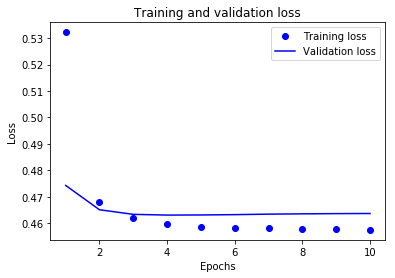

In [73]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

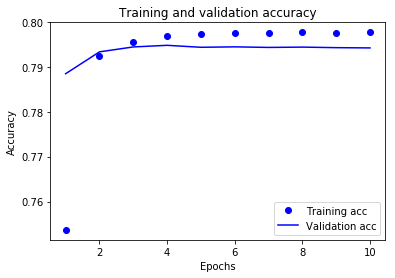

In [74]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [65]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

1000/1000 [==============================] - 4s 3ms/step - loss: -1.2683 - accuracy: 0.3889
0.389606237411499


In [67]:
examples = [
  "Today is a great day!",
  "This sentence is rather neutral",
  "This show is terrible!"
]

export_model.predict(examples)

array([[0.72702926],
       [0.51496404],
       [0.19550711]], dtype=float32)